<h1>San Francisco as a Travel Destination</h1>

<h2>Introduction - Business Problem</h2>

<p>In this project, we will evaluate the City of San Francisco as a travel destination for tourists. This evaluation will be of interest for stakeholders in industries related to tourism, travel agencies, as well as for people who are simply trying to decide on a destination for their next vacation.</p>
<p>The main things to think about when it comes to travel destinations are the availability of suitable accommodation options such as hotels and B&B's, shopping options such as malls and plazas, and of course the diversity of tourist atractions; these are the points that this evaluation will be built on.</p>

<h2>Data</h2>

<ul>Based on definition of our problem, the factors that will influence our decission are:
    <li>Shopping Options (mainly, Shopping Malls and Shopping Plazas): Availability - Rating.</li>
        <li>Tourist Spots (mainly, Museums, Music Venues, and Theme Parks): Availability - Rating - Affordability.</li>
        <li>Accomadation Options (mainly, Hotels, Hostels, and Bead & Breakfast's): Availability - Rating - Affordability.</li></ul>
<p>We will rely on the Foursquare API to retrieve the necessary data about venues in San Francisco, and then we'll conduct further analysis to obtain the results we need.</p>
        <p><u>P.S: As stated in the <a href='https://developer.foursquare.com/docs/resources/categories'>Foursquare documentation</a>, each of these categories includes sub-categories (Museum: Art Museum, History Museum,..) so by analyzing them we are aslo analyzing their sub-categories.</u></p>

<h4>Before we begin, let's import all the necessary libraries we'll be using:</h4>

In [87]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

import datetime

import time

import csv

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge
Libraries imported.


<h3>Foursquare API:</h3>
</br><p>The data we need is basically all the venues in San Francisco, and the most important metadata related to these venues that we need is (Category - Rating - Price - Longitude - Latitude).</p>

<h4>First, define the Foursquare credentials and version:</h4>

In [88]:
# The code was removed by Watson Studio for sharing.

<h5>Note that as of April 12th 2018, Foursqaure inforced limitations on data retrieval through its API when it comes to unpaid accounts, so I'm using a paid developer's account to execute the follwing code; if you try to execute it using the credentials from a free acount you will only get an empty dataframe.</h5>

<p>The following code will return the venues that exist within a specified bounding box of coordinates that defines the City of San Francisco (I calculated the bounding box coordinates with the help of <a href='bboxfinder.com'>bbox finder</a>), as well as the metadata related to them. The bounding box is broken into sub-bounding boxes as a form of grid search (by default, the grid_size is 100, so 100x100=10000 searches total).</p>

<br><h4>First, we'll create a dataframe that contains the bounding box coordinates of San Francisco:<h4>

In [89]:
sfbb_data = {'LeftBound': [-122.516441], 'BottomBound': [37.702072], 'RightBound': [-122.37276], 'TopBound': [37.811818]}
sfbb = pd.DataFrame(data=sfbb_data)
sfbb

,BottomBound,LeftBound,RightBound,TopBound
0,37.702072,-122.516441,-122.37276,37.811818


<h4>Next, we'll retrieve the data on the venues that exist within that bounding box and save it in a CSV file, and later read it into a dataframe:</h4>

In [90]:
#Number of API calls to /venue endpoint will be GridSize^2
GridSize = 100

#Get all Venue IDs for venues within the bounding box.
def get_delta(lower, upper, length):
    return (upper - lower)/length

lat_delta = get_delta(sfbb['TopBound'], sfbb['BottomBound'], GridSize)
long_delta = get_delta(sfbb['LeftBound'], sfbb['RightBound'], GridSize)

search_params = {
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
    'intent': 'browse',
    'limit': 50,
    'v': '20180218'
}

venue_ids = set()
search_count = 0

for lat in range(GridSize):
    for long in range(GridSize):
        ne_lat = sfbb['TopBound'] + lat * lat_delta
        ne_long = sfbb['LeftBound'] + (long+1) * long_delta

        search_params.update({'ne': '{},{}'.format(ne_lat, ne_long),
                              'sw': '{},{}'.format(ne_lat + lat_delta,
                                                   ne_long - long_delta)})

        r = requests.get('https://api.foursquare.com/v2/venues/search',
                         params=search_params) #Send the GET request

        if 'venues' in r.json()['response']:
            venues = r.json()['response']['venues']

            for venue in venues:
                venue_ids.add(venue['id'])

        search_count += 1

        # gets fussy when more than 5000 requests/hr
        if search_count % 5000 == 0:
            time.sleep(60*60)

        time.sleep(0.1)


# Get and process the data for each unique Venue.

venue_params = {
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
    'v': '20180218'
}

venue_ids_list = list(venue_ids)   # cannot iterate a set, so must coerce list
venue_count = 0

with open('foursquare_venues.csv', 'w', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'name', 'categories', 'lat', 'long', 'num_checkins',
                     'num_likes', 'price', 'rating',
                     'num_ratings', 'url_venue', 'url_foursquare'])

    for venue_id in venue_ids_list:
        r = requests.get(
            'https://api.foursquare.com/v2/venues/{}'.format(venue_id),
            params=venue_params)

        if 'venue' in r.json()['response']:
            venue = r.json()['response']['venue']

            id = venue_id
            name = venue.get('name', '')
            lat = venue.get('location', {}).get('lat', '')
            long = venue.get('location', {}).get('lng', '')
            num_checkins = venue.get('stats', {}).get('checkinsCount', '')
            num_likes = venue.get('likes', {}).get('count', '')
            rating = venue.get('rating', '')
            num_ratings = venue.get('ratingSignals', '')
            price = venue.get('price', {}).get('tier')
            url_venue = venue.get('url', '')
            url_foursquare = venue.get('shortUrl', '')

            # categories is an empty list if there are none.
            categories = venue.get('categories', '')
            if len(categories) == 0:
                categories = ''
            else:
               categories = ', '.join([x['name'] for x in categories])

            writer.writerow([id, name, categories, lat, long, num_checkins,
                            num_likes, price, rating,
                             num_ratings, url_venue, url_foursquare])

        venue_count += 1

        # the venues/* endpoint has a rate limit of 5000 requests/hr
        if venue_count % 5000 == 0:
            time.sleep(60*60)

        time.sleep(0.1)
        
#Save the results into a dataframe
sfdf = pd.read_csv('foursquare_venues.csv')
sfdf.head()

,id,name,categories,lat,long,num_checkins,num_likes,price,rating,num_ratings,url_venue,url_foursquare
0,4ec6e39799115348d857eef7,Pioneer Monument (James Lick Monument),Art Gallery,37.779800,-122.416135,43,0.0,NaN,NaN,NaN,http://www.sfartscommission.org,http://4sq.com/sCDvwW
1,4ee2341cf9ab478e5935d27d,Calibre One,Office,37.783210,-122.393368,10,0.0,NaN,NaN,NaN,NaN,http://4sq.com/t4zgoG
2,4e9126889a52db7dba8dc0a0,The Red Room,Nightlife Spot,37.734963,-122.479835,7,0.0,NaN,NaN,NaN,NaN,http://4sq.com/qO5NSG
3,53503f72498ef2dd1139298b,"Strip, Cuddle Up And Nap",Residential Building (Apartment / Condo),37.712424,-122.430949,2,0.0,NaN,NaN,NaN,NaN,http://4sq.com/1lcZpnN
4,4a1f1787f964a520057c1fe3,Madusalon,Salon / Barbershop,37.772272,-122.437238,529,17.0,NaN,7.4,30.0,http://www.madusalon.com,http://4sq.com/5mEGxl


<h3>Cleaning up the dataframe</h3>
<p>Now that we have our dataframe, we'll drop all the unnecessary columns and only leave:</p>
</br><p>1. Categories and rating (and remove all rows that contain NaN rating value) to analyze the rating of the venues.</p>
</br><p>2. Categories and price (and remove all rows that contain NaN pricevalue) to analyze the affordability of the venues.</p>

<h4>First, create dataframe for rating analysis:</h4>

In [91]:
#Drop unnecessary columns (leave only categories and rating)
sfdf1 = sfdf.drop(columns=['id', 'lat', 'long', 'num_checkins', 'url_venue', 'url_foursquare', 'num_ratings', 'num_likes', 'price'])

#Then drop the rows where at least one element is missing
sfdf1 = sfdf1.dropna()
print("The dataframe we'll be using for rating analysis: ")
sfdf1.head()

The dataframe we'll be using for rating analysis: 


,name,categories,rating
4,Madusalon,Salon / Barbershop,7.4
10,Mr. Smith's,"Bar, Lounge, Nightclub",6.7
18,Hillside Supper Club,American Restaurant,8.2
25,Hand Touch Nails,Spa,7.7
38,Southern Pacific Brewing,"Brewery, American Restaurant, Burger Joint",8.7


<h4>Second, create dataframe for affordability analysis:</h4>

In [92]:
#Drop unnecessary columns (leave only categories and rating)
sfdf2 = sfdf.drop(columns=['id', 'lat', 'long', 'num_checkins', 'url_venue', 'url_foursquare', 'num_ratings', 'num_likes', 'rating'])

#Then drop the rows where at least one element is missing
sfdf2 = sfdf2.dropna()
print("The dataframe we'll be using for affordability analysis: ")
sfdf2.head()

The dataframe we'll be using for affordability analysis: 


,name,categories,price
8,Lady Falcon Coffee Club,"Food Truck, Coffee Shop",1.0
10,Mr. Smith's,"Bar, Lounge, Nightclub",2.0
11,Madame Kim's Annex,Speakeasy,3.0
18,Hillside Supper Club,American Restaurant,2.0
21,The Treehouse @ Public Works,Lounge,3.0


<p>The dataframes we'll be using for analysis are now ready:
<br><br>We have a dataframe that contains all the names, categories, and ratings of the venues, which we'll use for rating analysis.
<br><br>And another dataframe that contains all the names, categories, and prices of the venues, which we'll use for affordability analysis.</p>

<h4>Before we move on to the analysis, let's get a sense of how much data we're working with:</h4>

In [93]:
print('Total number of venues with available metadat in San Francisco: ', sfdf.shape[0])
print('Total number of venues with available ratings data in San Francisco: ', sfdf1.shape[0])
print('Total number of venues with available affordability data in San Francisco: ', sfdf2.shape[0])

Total number of venues with available metadat in San Francisco:  44425
Total number of venues with available ratings data in San Francisco:  8167
Total number of venues with available affordability data in San Francisco:  8365


<h2>Methodology</h2>
<p>In this project, we aim to evaluate the city of San Francisco as a tourist/travel destination based on available information about its venues.
    <ul>This evaluation will be built on the following aspects:
        <li>Shopping Options (mainly, Shopping Malls and Shopping Plazas): Availability - Rating.</li>
        <li>Tourist Spots (mainly, Museums, Music Venues, and Theme Parks): Availability - Rating - Affordability.</li>
        <li>Accomadation Options (mainly, Hotels, Hostels, and Bead&Breakfast's): Availability - Rating - Affordability.</li></ul>
        Keep in mind that each of those categories contain its own subcategories that will automatically be included in the analysis.
    <br><br>In the previous step, we have acquired a dataframe that contains all the venues in San Francisco as well as their relevant metadata from Foursquare, then, to facilitate the analysis process, we divided it into two dataframes: The first one will be used to analyze the venues' ratings, and the second one will be used to analyze their affordability.</p>

<h3>Analysing the data</h3>
<p>We will now analyze the data available on San Francisco venues that have to do with shopping options, tourist spots, and accommodation options.</p>
<ol>Reminder: the aspects we are analyzing are:
    <li>Shopping Options (mainly, Shopping Malls and Shopping Plazas): Availability - Rating.</li>
        <li>Tourist Spots (mainly, Museums, Music Venues, and Theme Parks): Availability - Rating - Affordability.</li>
        <li>Accomadation Options (mainly, Hotels, Hostels, and Bead & Breakfast's): Availability - Rating - Affordability.</li></ol>

<h3>1. Shopping Options:</h3>

<h4>Shopping Options - Availability:</h4>

In [94]:
#Number of shopping malls
numofMall = (sfdf.categories.str.contains('Shopping Mall')).sum()
print ("Number of shopping malls in San Francisco: ", numofMall)

#Number of shopping plazas
numofPlaza = (sfdf.categories.str.contains('Shopping Plaza')).sum()
print ("Number of shopping plazas in San Francisco: ", numofPlaza)
print()

#total number of shopping options:
totnumShop = numofMall + numofPlaza
print ("Total number of shopping options:", totnumShop)

Number of shopping malls in San Francisco:  34
Number of shopping plazas in San Francisco:  2

Total number of shopping options: 36


<h4>Shopping Options - Rating:</h4>

In [95]:
#Number of rated shopping malls
numofMallR = (sfdf1.categories.str.contains('Shopping Mall')).sum()
print ("Number of rated shopping malls in San Francisco: ", numofMallR)

#Number of rated shopping plazas
numofPlazaR = (sfdf1.categories.str.contains('Shopping Plaza')).sum()
print ("Number of rated shopping plazas in San Francisco: ", numofPlazaR)
print()

#Total number of shopping options
totnumShopR = numofMallR + numofPlazaR
print("Tatal number of rated shopping options in San Francisco: ", totnumShopR)
print()

#Average rating of shopping options:
ratShop = sfdf1.loc[sfdf1.categories.str.contains('Shopping Mall'), 'rating'].mean() + sfdf1.loc[sfdf1.categories.str.contains('Shopping Plaza'), 'rating'].mean()
ratShop = ratShop/2
print("Average rating of shopping options in San Francisco: %.2f" % ratShop)

Number of rated shopping malls in San Francisco:  19
Number of rated shopping plazas in San Francisco:  2

Tatal number of rated shopping options in San Francisco:  21

Average rating of shopping options in San Francisco: 7.74


<h4>Let's visualize our findings on shopping options:</h4>

Text(0,0.5,'Rating of shopping mall / plaza')

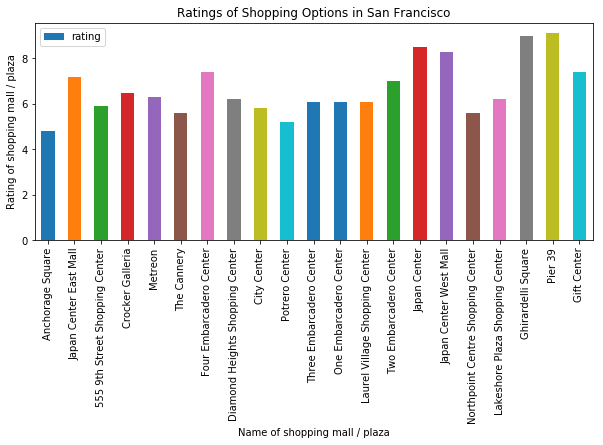

In [96]:
#Generate bar chart for shopping options' ratings
SO = ['Shopping Mall', 'Shopping Plaza']
SOR = sfdf1[sfdf1['categories'].str.contains('|'.join(SO))]
SOR.plot.bar(x='name', y='rating', figsize=[10,4])
plt.title('Ratings of Shopping Options in San Francisco')
plt.xlabel('Name of shopping mall / plaza')
plt.ylabel('Rating of shopping mall / plaza')

<h3>2. Tourist Spots:</h3>

<h4>Tourist Spots - Availability:</h4>

In [97]:
#Number of museums
numofMuseum = (sfdf.categories.str.contains('Museum')).sum()
print ("Nuum of museums in San Francisco: ", numofMuseum)

#Number of music venues
numofMusic = (sfdf.categories.str.contains('Music Venue')).sum()
print ("Number of music venues in San Francisco: ", numofMusic)

#Number of Theme Parks
numofPark = (sfdf.categories.str.contains('Theme Park')).sum()
print ("Number of theme parks in San Francisco: ", numofPark)
print()

#total number of tourist spots
totnumTour = numofMuseum + numofMusic + numofPark
print("Total number of tourist spots in San Francisco: ", totnumTour)
print()

Nuum of museums in San Francisco:  150
Number of music venues in San Francisco:  178
Number of theme parks in San Francisco:  14

Total number of tourist spots in San Francisco:  342



<h4>Let's check the diversity of available tourist attractions:</h4>

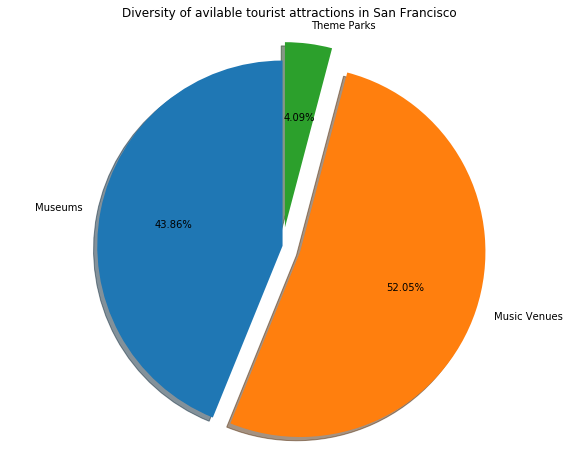

In [98]:
#Generate pie chart
labels = 'Museums', 'Music Venues', 'Theme Parks'
sizes = [numofMuseum, numofMusic, numofPark]
explode = (0, 0.1, 0.1)

fig1, ax1 = plt.subplots(figsize=[10,8])
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Diversity of avilable tourist attractions in San Francisco')
plt.show()

<h4>Tourist Spots - Rating:</h4>

In [99]:
#Number of rated museums
numofMuseumR = (sfdf1.categories.str.contains('Museum')).sum()
print ("Number of rated museums in San Francisco: ", numofMuseumR)

#Number of rated music venues
numofMusicR = (sfdf1.categories.str.contains('Music Venue')).sum()
print ("Number of rated music venues in San Francisco: ", numofMusicR)

#Number of rated Theme Parks
numofParkR = (sfdf1.categories.str.contains('Theme Park')).sum()
print ("Number of rated theme parks in San Francisco: ", numofParkR)
print()

#Total number of rated tourist spots
totnumTourR = numofMuseumR+ numofMusicR + numofParkR
print("Total number of rated tourist spots in San Francisco: ", totnumTourR)
print()

#average rating of tourist spots:
ratTour = sfdf1.loc[sfdf1.categories.str.contains('Museum'), 'rating'].mean() + sfdf1.loc[sfdf1.categories.str.contains('Music Venue'), 'rating'].mean() + sfdf1.loc[sfdf1.categories.str.contains('Theme Park'), 'rating'].mean()
ratTour = ratTour/3
print("Average rating of tourist spots in San Francisco: %.2f" % ratTour)

Number of rated museums in San Francisco:  56
Number of rated music venues in San Francisco:  50
Number of rated theme parks in San Francisco:  6

Total number of rated tourist spots in San Francisco:  112

Average rating of tourist spots in San Francisco: 7.91


<h4>Let's visualize the ratings for the tourist spots:</h4>

Ratings of museums in San Francisco:


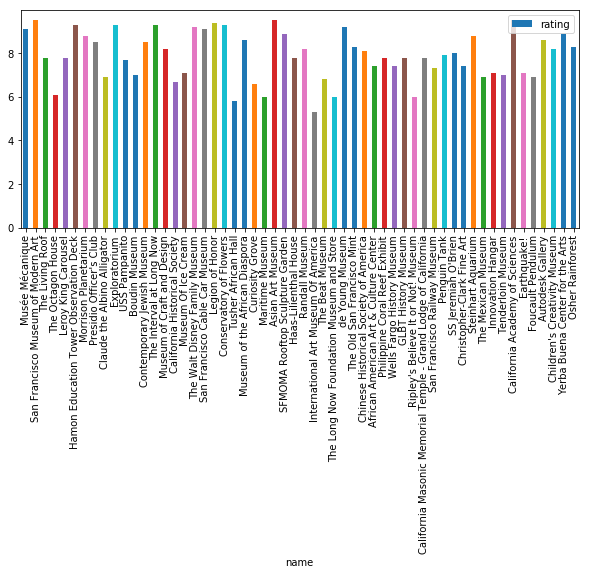

In [100]:
#Generate bar chart for Museums' ratings
MUR = sfdf1[sfdf1['categories'].str.contains('Museum')]
print('Ratings of museums in San Francisco:')
MUR.plot.bar(x ='name', y='rating', figsize=[10,4])

Ratings of music venues in San Francisco:


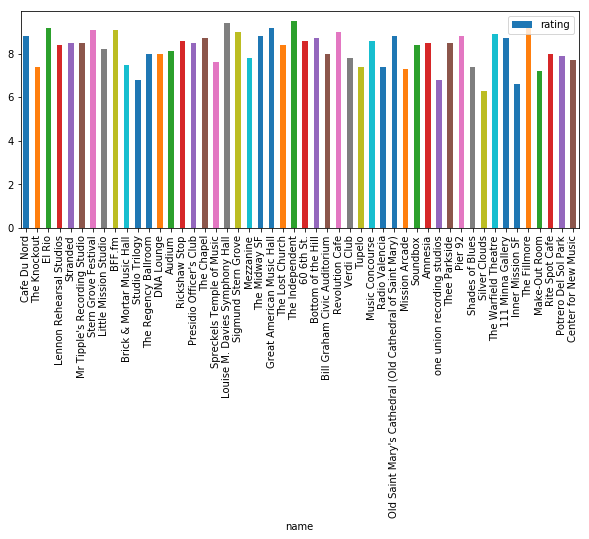

In [101]:
#Generate bar chart for tourist attractions' ratings
MCR = sfdf1[sfdf1['categories'].str.contains('Music Venue')]
print('Ratings of music venues in San Francisco:')
MCR.plot.bar(x ='name', y='rating', figsize=[10,4])

Ratings of theme parks in San Francisco:


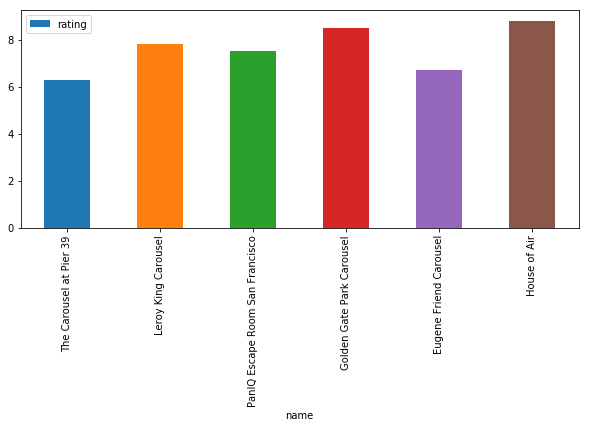

In [102]:
#Generate bar chart for tourist attractions' ratings
TPR = sfdf1[sfdf1['categories'].str.contains('Theme Park')]
print('Ratings of theme parks in San Francisco:')
TPR.plot.bar(x ='name', y='rating', figsize=[10,4])

<h4>Tourist Spots - Affordability:</h4>

In [103]:
#Price range for museums
minMuseum = sfdf2.loc[sfdf2.categories.str.contains('Museum'), 'price'].min()
maxMuseum = sfdf2.loc[sfdf2.categories.str.contains('Museum'), 'price'].max()
print("Price range for museums in San Francisco: {", minMuseum, " - ", maxMuseum, "}")

#Price range for music venues
minMusic = sfdf2.loc[sfdf2.categories.str.contains('Music Venue'), 'price'].min()
maxMusic = sfdf2.loc[sfdf2.categories.str.contains('Music Venue'), 'price'].max()
print("Price range for music venues in San Francisco: {", minMusic, " - ", maxMusic, "}")

#Price range for theme parks
minPark = sfdf2.loc[sfdf2.categories.str.contains('Theme Parks'), 'price'].min()
maxPark = sfdf2.loc[sfdf2.categories.str.contains('Theme Parks'), 'price'].max()
print("Price range for theme parks in San Francisco: {", minPark, " - ", maxPark, "}")

Price range for museums in San Francisco: { 2.0  -  2.0 }
Price range for music venues in San Francisco: { 1.0  -  2.0 }
Price range for theme parks in San Francisco: { nan  -  nan }


<h3>3. Accommodation Options:</h3>

<h4>Accommodation Options - Availability:</h4>

In [104]:
#Number of hotels
numofHotel = (sfdf.categories.str.contains('Hotel')).sum()
print ("Number of hotels in San Francisco: ", numofHotel)

#Number of hostels
numofHostel = (sfdf.categories.str.contains('Hostel')).sum()
print ("Number of hostels in San Francisco: ", numofHostel)

#Number of bed and breakfast
numofBed = (sfdf.categories.str.contains('Bed & Breakfast')).sum()
print ("Number of Bed & Breakfast's in San Francisco: ", numofBed)
print()

#total number of accomadation options
totnumAcc = numofHotel + numofHostel + numofBed
print("Total number of tourist spots in San Francisco: ", totnumAcc)

Number of hotels in San Francisco:  418
Number of hostels in San Francisco:  44
Number of Bed & Breakfast's in San Francisco:  121

Total number of tourist spots in San Francisco:  583


<h4>Let's check the diversity of available accommodation options:</h4>

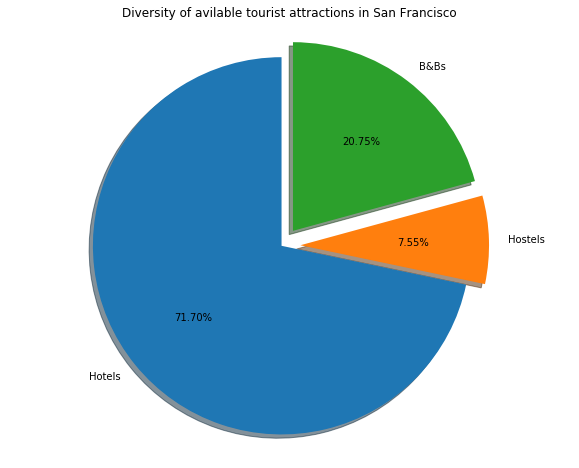

In [105]:
#Generate pie chart
labels = 'Hotels', 'Hostels', 'B&Bs'
sizes = [numofHotel, numofHostel, numofBed]
explode = (0, 0.1, 0.1)

fig1, ax1 = plt.subplots(figsize=[10,8])
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Diversity of avilable tourist attractions in San Francisco')
plt.show()

<h4>Accommodation Options - Rating:</h4>

In [106]:
#number of rated hotels
numofHotelR = (sfdf1.categories.str.contains('Hotel')).sum()
print ("Number of rated hotels in San Francisco: ", numofHotelR)

#number of rated hostels
numofHostelR = (sfdf1.categories.str.contains('Hostel')).sum()
print ("Number of rated Hostels in San Francisco: ", numofHostelR)

#number or rated bed & breakfast's
numofBedR = (sfdf1.categories.str.contains('Bed & Breakfast')).sum()
print ("Number or rated Bed & Breakfast's in San Francisco: ", numofBedR)
print()

#Total number of rated accommodation options
totnumAccR = numofHotelR+ numofHostelR + numofBedR
print("Total number of rated accommodation options in San Francisco: ", totnumAccR)
print()

#average rating of accommodation options:
ratAcc = sfdf1.loc[sfdf1.categories.str.contains('Hotel'), 'rating'].mean() + sfdf1.loc[sfdf1.categories.str.contains('Hostel'), 'rating'].mean() + sfdf1.loc[sfdf1.categories.str.contains('Bed & Breakfast'), 'rating'].mean()
ratAcc = ratAcc/3
print("Average rating of accomadation options in San Francisco: %.2f" % ratAcc)

Number of rated hotels in San Francisco:  215
Number of rated Hostels in San Francisco:  19
Number or rated Bed & Breakfast's in San Francisco:  16

Total number of rated accommodation options in San Francisco:  250

Average rating of accomadation options in San Francisco: 6.67


<h4>Lets's visualize our finding on accommodation options:</h4>

Ratings of hotels in San Francisco:


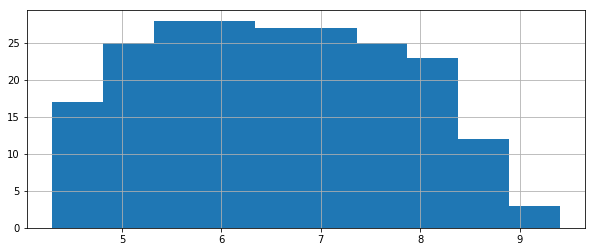

In [107]:
#Generate histogram for hotels' ratings
HTR = sfdf1[sfdf1['categories'].str.contains('Hotel')]
print('Ratings of hotels in San Francisco:')
HTR.rating.hist(bins=10, figsize=[10,4])

Ratings of hostels in San Francisco:


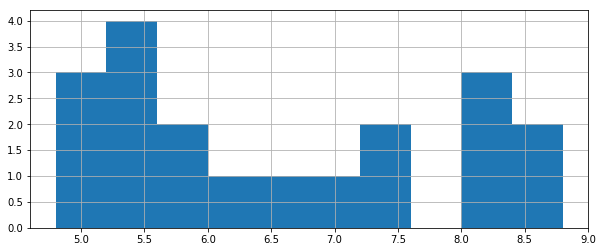

In [108]:
#Generate histogram for hotels' ratings
HSR = sfdf1[sfdf1['categories'].str.contains('Hostel')]
print('Ratings of hostels in San Francisco:')
HSR.rating.hist(bins=10, figsize=[10,4])

Ratings of Bed & Breakfasts in San Francisco:


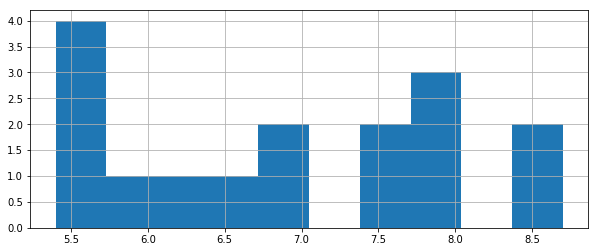

In [110]:
#Generate histogram for B&Bs' ratings
BBR = sfdf1[sfdf1['categories'].str.contains('Bed & Breakfast')]
print('Ratings of Bed & Breakfasts in San Francisco:')
BBR.rating.hist(bins=10, figsize=[10,4])

<h4>Accomodation Options - Affordability:</h4>

In [111]:
#Price range for hotels
minHotel = sfdf2.loc[sfdf2.categories.str.contains('Hotel'), 'price'].min()
maxHotel = sfdf2.loc[sfdf2.categories.str.contains('Hotel'), 'price'].max()
print("Price range for hotels in San Francisco: {", minHotel, " - ", maxHotel, "}")

#Price range for hostels
minHostel = sfdf2.loc[sfdf2.categories.str.contains('Hostel'), 'price'].min()
maxHostel = sfdf2.loc[sfdf2.categories.str.contains('Hostel'), 'price'].max()
print("Price range for hostels in San Francisco: {", minHostel, " - ", maxHostel, "}")

#Price range for bed & breakfast's
minBed = sfdf2.loc[sfdf2.categories.str.contains('Bed & Breakfast'), 'price'].min()
maxBed = sfdf2.loc[sfdf2.categories.str.contains('Bed & Breakfast'), 'price'].max()
print("Price range for bed & breakfast's in San Francisco: {", minBed, " - ", maxBed, "}")

Price range for hotels in San Francisco: { 1.0  -  3.0 }
Price range for hostels in San Francisco: { 3.0  -  3.0 }
Price range for bed & breakfast's in San Francisco: { nan  -  nan }


<h3>San Fransisco Venues' Map:</h3>
<p>We will now visualize our data by generating a map of San Fransisco with the venues that we have analyzed superimposed on top of it.</p>

<h4>First, we will create a dataset that only includes those venues as well as their price, rating, and latitude and longitude coordinates:<h4>

In [112]:
#Drop unnecessary columns
sfdf3 = sfdf.drop(columns=['price', 'rating', 'id', 'num_checkins', 'url_venue', 'url_foursquare', 'num_ratings', 'num_likes'])

#Create a list of the venue categories that we want
venueCat = ['Shopping Mall', 'Shopping Plaza', 'Musem', 'Music Venue', 'Theme Park', 'Hotel', 'Hostel', 'Bed & Breakfast']

#Create a dataframe that only contains those venues, and ignore the values that are unavailable
sfdf3 = sfdf3[sfdf3['categories'].str.contains('|'.join(venueCat), na = False)]
print(sfdf3.shape)
sfdf3.head()

(799, 4)


,name,categories,lat,long
74,Tonga Room & Hurricane Bar,"Tiki Bar, Asian Restaurant, Hotel Bar",37.792261,-122.409636
173,BridgePoint Inn,"Motel, Hotel",37.705262,-122.408040
216,Cafe Du Nord,"Music Venue, Restaurant",37.766490,-122.430200
227,Belvedere House B & B,Bed & Breakfast,37.761904,-122.447663
348,Music City Hotel/Hostel,"Hostel, Hotel",37.788695,-122.419595


<h4>So the dataframe consists of 799 venues. In order to reduce computational cost, let's just work with the first 150 venues in the dataset.</h4>

In [113]:
limit = 150
sfdf33 = sfdf3.iloc[0:limit, :]
sfdf33.shape

(150, 4)

<h4>Next, we'll generate the map:</h4>

In [114]:
# San Francisco latitude and longitude values
latitude = 37.77
longitude = -122.42

# create map
sanfran_map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Mapbox Bright')

<h4>Then, we'll superimpose the locations of the venues onto the map:</h4>

In [115]:
# instantiate a feature group for the venues in the dataframe
sanfran_venues = folium.map.FeatureGroup()

# loop through the venues and add each to the venues feature group
for lat, lng, in zip(sfdf33.lat, sfdf33.long):
    sanfran_venues.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, 
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add pop-up text to each marker on the map
latitudes = list(sfdf33.lat)
longitudes = list(sfdf33.long)
labels = list(sfdf33.name)

for lat, lng in zip(latitudes, longitudes):
    label = folium.Popup(labels, parse_html=True)
    folium.Marker([lat, lng], popup=label).add_to(sanfran_map)    
    
# add incidents to map
sanfran_map.add_child(sanfran_venues)


<h3>Results and Discussion</h3>

<p>Let’s discuss our findings by category:
<br><br>1. Shopping options: When it comes to shopping options, it seems that the city of San Francisco has a less than impressive number of shopping options (malls and plazas) available, however it makes up for with a respectable average rating of 7.74/10. After visualizing the ratings for shopping options, we found that none of their ratings goes is below 5, and most of them are between 7 and 9.
<br><br>2. Tourist Spots: When it comes to tourist spots, San Francisco is at an abundance. There is a relatively high diversity of tourist attractions available, with a noticeably lower number of theme parks compared to museums and music venues. As for the ratings, most of the museums scored between 6 and 9 and none of them went below 5. Music venues showed better results as most of them scored between 7 and 9 and none of them went below 6.5. Same goes for theme parks which scored between 6 and 9. The tourist spots in San Francisco have an average rating of 7.91, which is very impressive. What was really note-worthy is how affordable the tourist spots turned out to be, especially compared to their relatively high ratings; both museums and music venues don’t go above 2 (on a scale of 1 to 4, 4 being the most pricey).
<br><br>3. Accommodation Options: When it comes to accommodation options, San Francisco delivers. There is a high number of options available, with a decent diversity. However, it seems like that high number has affected the average rating of accommodation options, which stands at 6.67. This number is not necessarily bad, but it implies that a considerable number of those venues has a rating of 5 and even below. This was proven when we visualized those ratings, and it turns out that most hotel ratings are between 5 and 8 and some of them went below 5. The most common ratings for hostels were 5~6 and 8~9, with the rest in between. Same thing for B&Bs. As for affordability, hotel prices ranged between 1 and 3 (understandably, considering the wide range of ratings they have), while hostels scored an even 3. There were no information available on B&B prices.</p>


<h3>Conclusion</h3>

<p>The purpose of this project was to get a feel of how well the city of San Francisco performs as a tourist/travel destination. We evaluated three main aspects: Shopping options based on their availability and ratings, tourist spots based on their availability, ratings and prices, an accommodation options based on their availability, ratings, and prices as well. We relied on the Foursquare API to get relevant data on venues in San Francisco to perform the previous analysis. While conducting the analysis, we used data visualization to get a better understanding of our findings.
    <br><br>Overall, San Francisco performed relatively well on all of these aspects, as the results showed it has a respectable number of highly-rated shopping options, an abundance of highly rated and very affordable tourist attractions, and a large collection of accommodation options with a wide range of ratings and prices to suit everyone.<p>
        <p>The final decisions will be made by stakeholders depending on their main objective, and other factors that come with it.</p>